https://nbviewer.org/github/bem4solvation/XPINNS/blob/xpinns/Main.ipynb

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math
import os

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model
from classes.cartesian.Preconditioner import Preconditioner
from classes.cartesian.Postprocessing import View_results
from classes.cartesian.Postprocessing import View_results_X
from classes.cartesian.XPINN import XPINN

## PINN

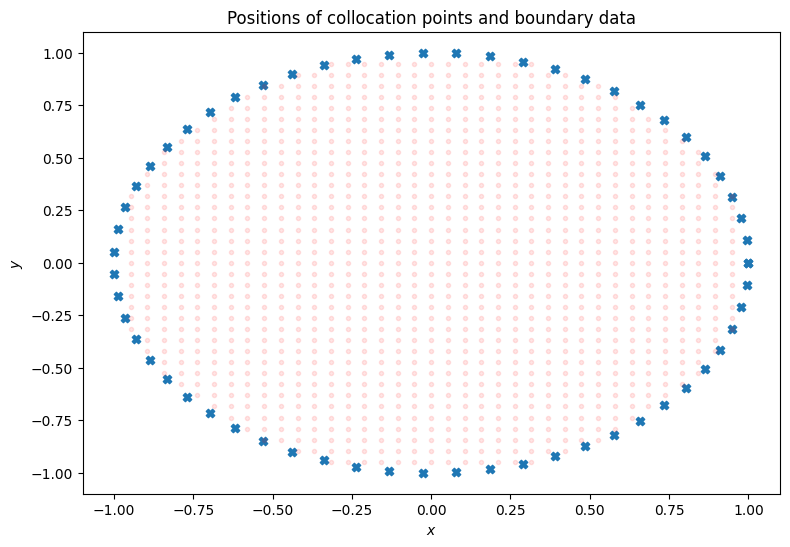

In [3]:
domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04

lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();



PINN_solver = PINN()

PINN_solver.adapt_PDE(PDE1)
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_solver.adapt_mesh(mesh1,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

In [4]:
PINN_solver.solve(N=4000,flag_time=False)

In [5]:
Post = View_results(PINN_solver)

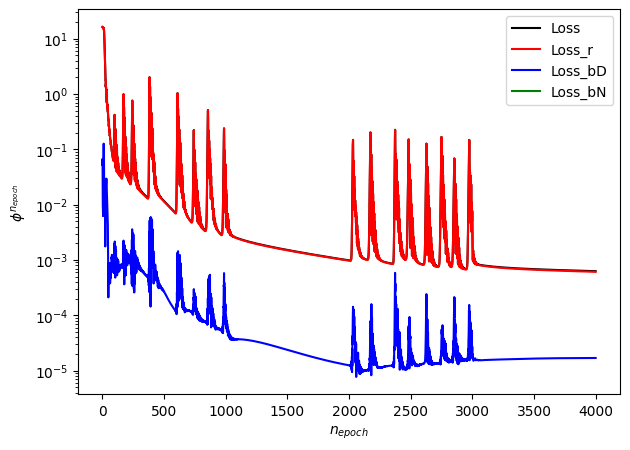

In [6]:
Post.plot_loss_history();

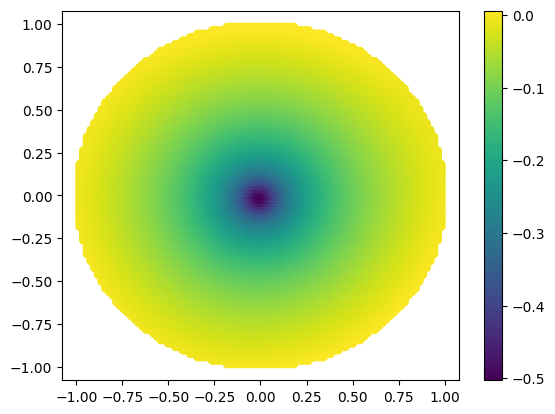

In [7]:
Post.plot_u_domain_countour()

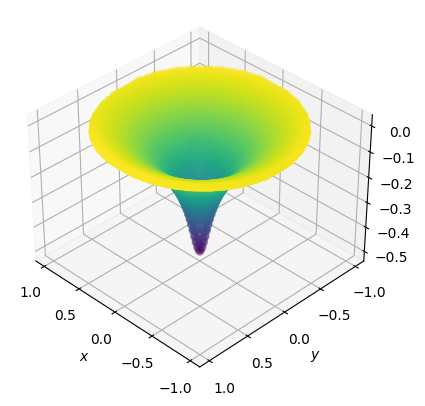

In [8]:
Post.plot_u_domain_surface()

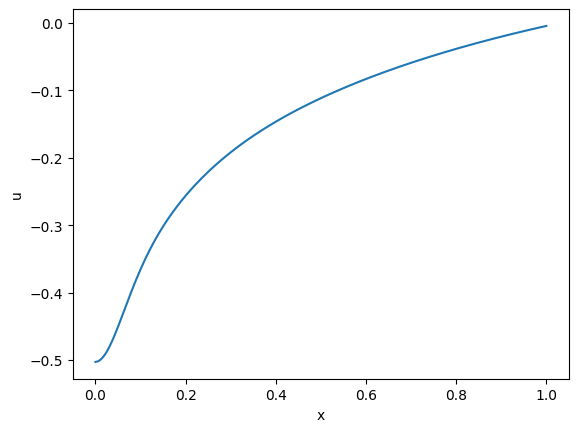

In [9]:
Post.plot_u_plane();

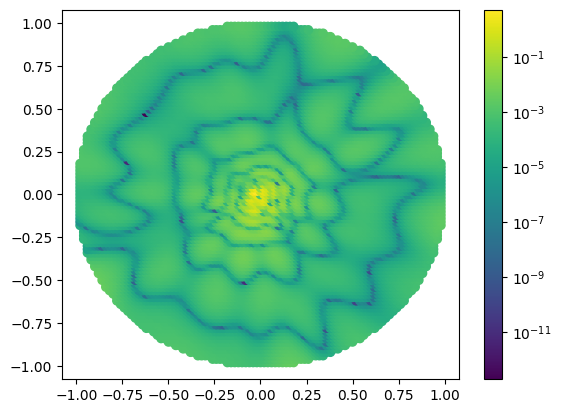

In [10]:
Post.plot_loss();

## XPINN

In [13]:
import numpy as np
import tensorflow as tf

In [14]:
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model
from classes.cartesian.Preconditioner import Preconditioner
from classes.cartesian.Postprocessing import View_results
from classes.cartesian.Postprocessing import View_results_X
from classes.cartesian.XPINN import XPINN
from classes.cartesian.PDE_Model import PDE_Model_2

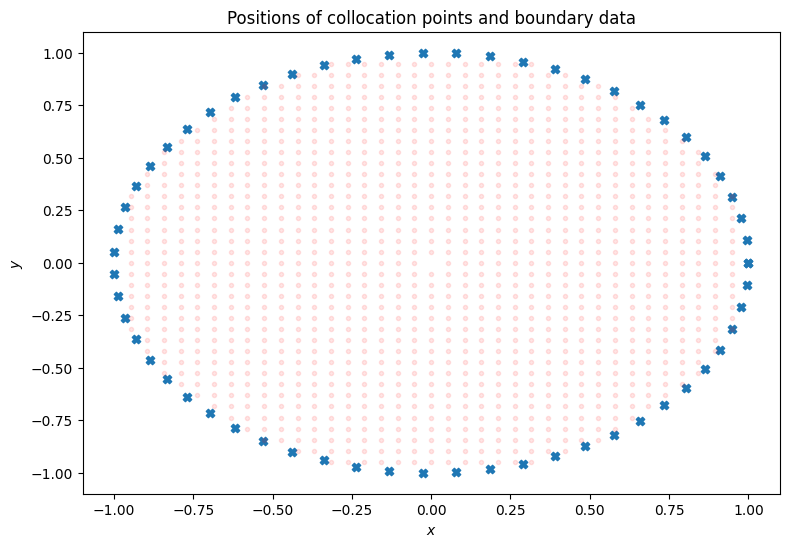

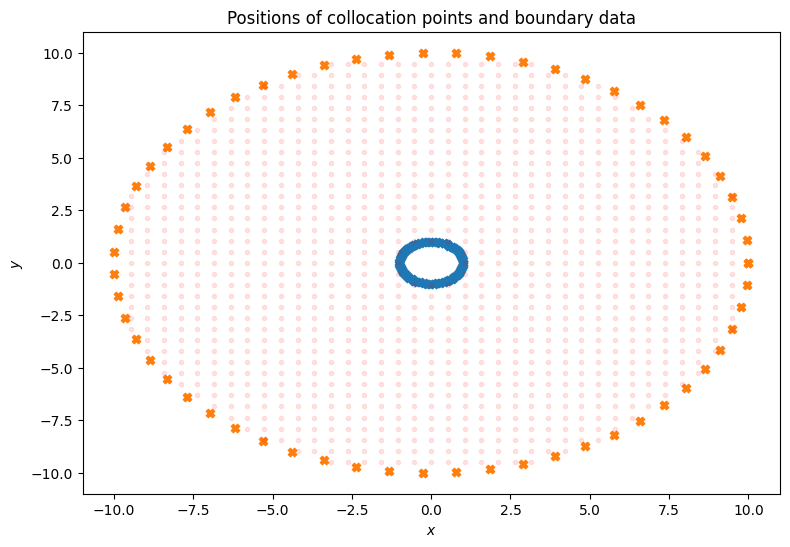

In [31]:
domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':(1.0/10)*np.log(10), 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.create_NeuralNets(PINN_NeuralNet,[lr,lr],[hyperparameters,hyperparameters])

In [32]:
XPINN_solver.solve(N=4000,flag_time=False)

In [33]:
Post = View_results_X(XPINN_solver,View_results)

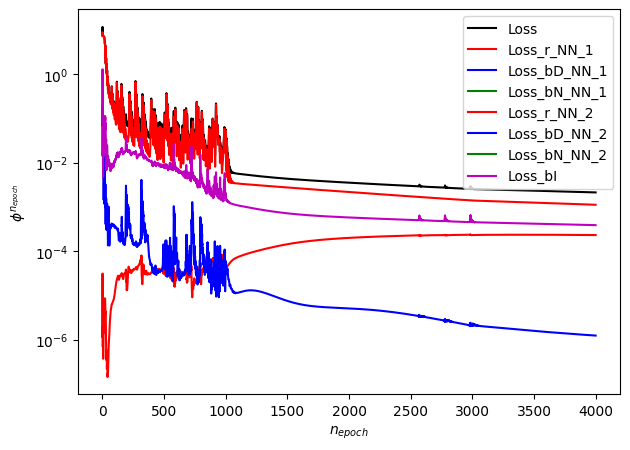

In [34]:
Post.plot_loss_history();

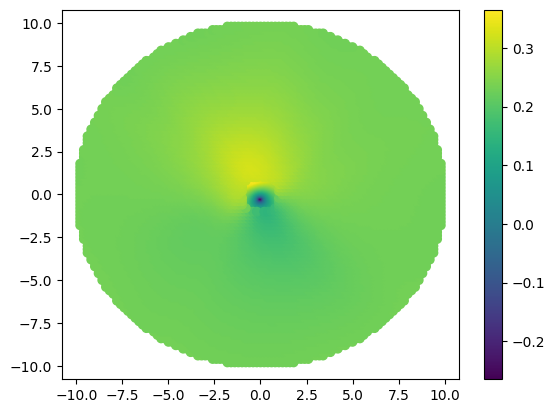

In [38]:
Post.plot_u_domain_countour()

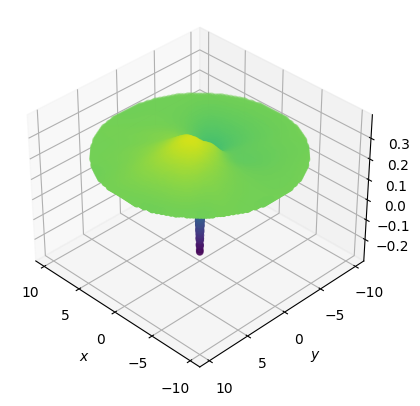

In [39]:
Post.plot_u_domain_surface()

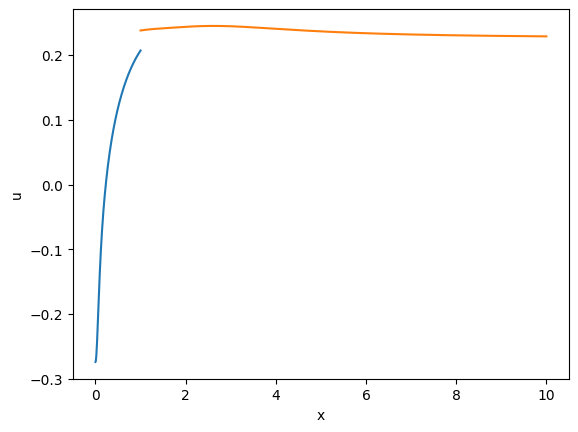

In [40]:
Post.plot_u_plane();

In [41]:
XPINN_solver.save_models('.saved_models',['Test_XPINN_int','Test_XPINN_ext'])

In [42]:
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model
from classes.cartesian.Preconditioner import Preconditioner
from classes.cartesian.Postprocessing import View_results
from classes.cartesian.Postprocessing import View_results_X
from classes.cartesian.XPINN import XPINN
from classes.cartesian.PDE_Model import PDE_Model_2

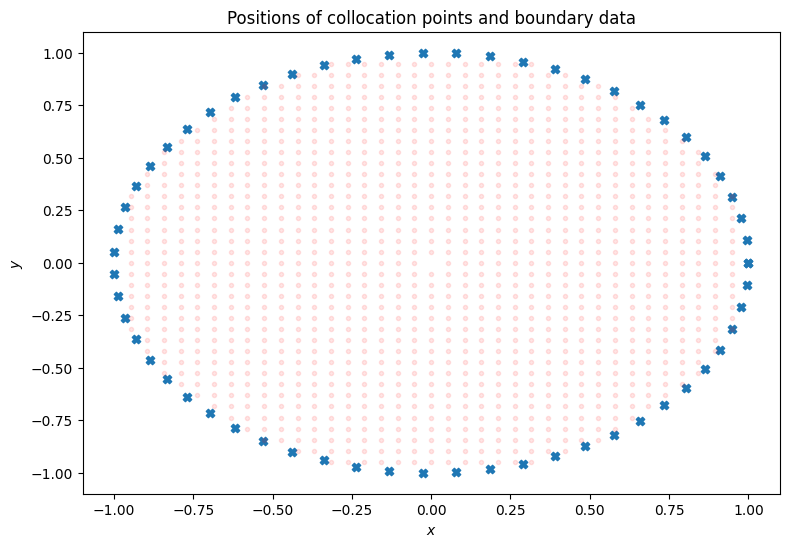

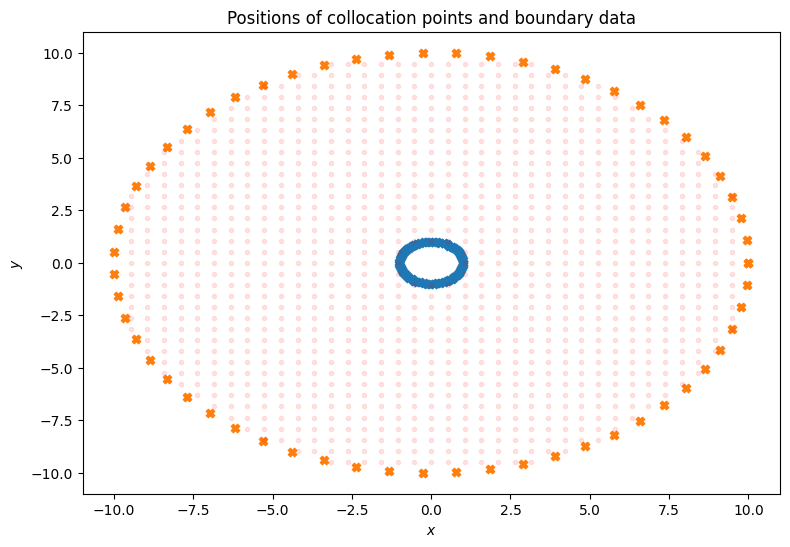

In [43]:
XPINN_solverl = XPINN(PINN)

domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04

vf = (1/(2*np.pi*10))*np.log(10)
lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':vf, 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();

XPINN_solverl = XPINN(PINN)

XPINN_solverl.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solverl.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solverl.load_NeuralNets('.saved_models',['Test_XPINN_int','Test_XPINN_ext'],[lr,lr])

In [44]:
Post = View_results_X(XPINN_solverl,View_results)

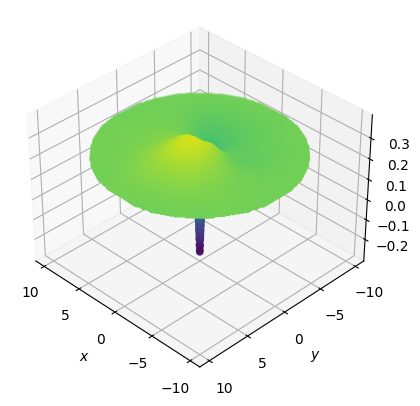

In [45]:
Post.plot_u_domain_surface();

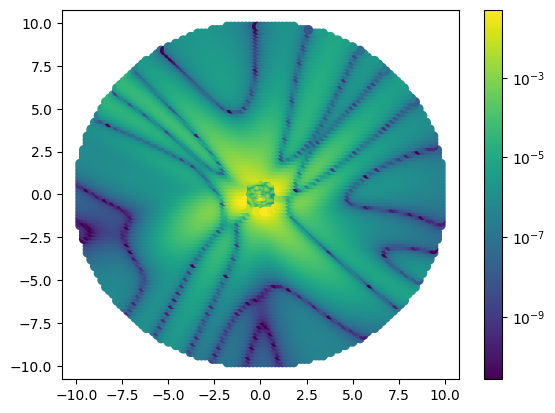

In [46]:
Post.plot_loss();

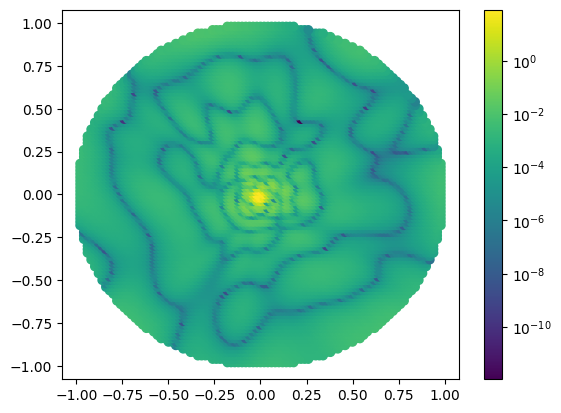

In [47]:
Post.Post[0].plot_loss();

In [1]:
import numpy as np

## Preaconditionate XPINN

In [2]:
from classes.cartesian.PINN import PINN_Precond
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model
from classes.cartesian.Preconditioner import Preconditioner
from classes.cartesian.Postprocessing import View_results
from classes.cartesian.Postprocessing import View_results_X
from classes.cartesian.XPINN import XPINN
from classes.cartesian.PDE_Model import PDE_Model_2

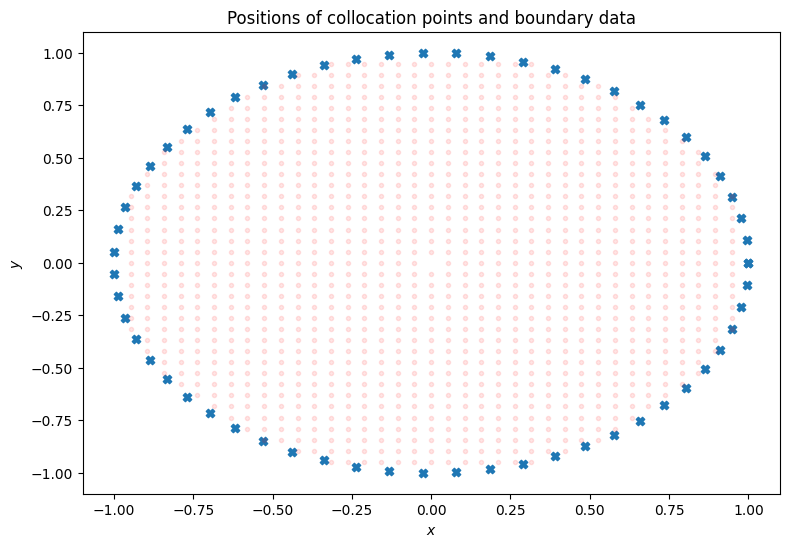

In [55]:
precond1 = Preconditioner()

domain1 = ([-1,1],[-1,1])
domain1 = precond1.set_domain(domain1)
precond1.epsilon = 1

lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0.05}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();


PINN_precond1 = PINN_Precond()

weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_precond1.adapt_mesh(mesh1,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_precond1.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

PINN_precond1.load_preconditioner(precond1)

In [56]:
PINN_precond1.preconditionate(N=4000, flag_time=False)

In [57]:
Post = View_results(PINN_precond1)

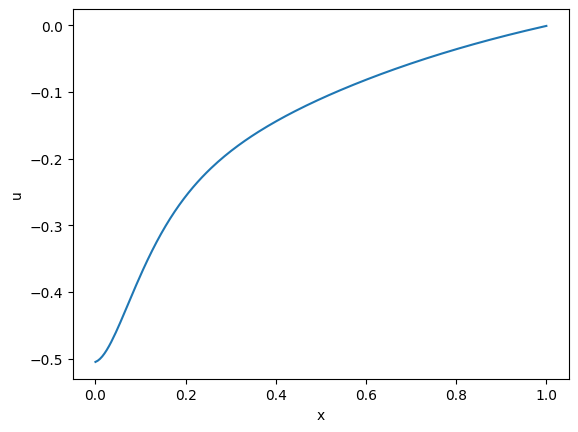

In [58]:
Post.plot_u_plane()

In [59]:
PINN_precond1.save_model('.saved_models','Test_precond_in')

INFO:tensorflow:Assets written to: c:\Users\achom\Desktop\Main\Code\Scientific Computing\PINNS\Code\.saved_models\Test_precond_in\assets


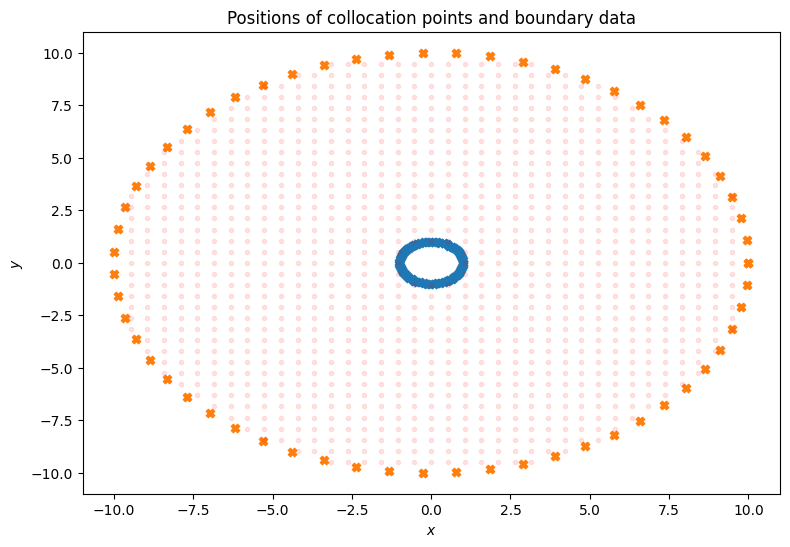

In [60]:
precond2 = Preconditioner()

domain2 = ([-10,10],[-10,10])
domain2 = precond2.set_domain(domain2)
precond2.epsilon = 10

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':np.log(10), 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();


PINN_precond2 = PINN_Precond()

weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_precond2.adapt_mesh(mesh2,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_precond2.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

PINN_precond2.load_preconditioner(precond2)



In [61]:
PINN_precond2.preconditionate(N=4000, flag_time=False)

In [62]:
Post = View_results(PINN_precond2)

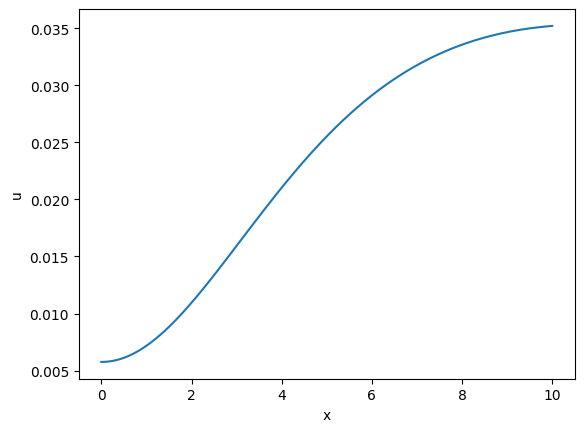

In [63]:
Post.plot_u_plane();

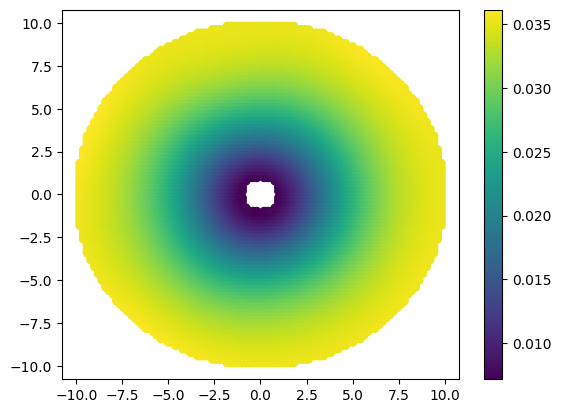

In [64]:
Post.plot_u_domain_countour()

In [65]:
PINN_precond2.save_model('.saved_models','Test_precond_ext')

INFO:tensorflow:Assets written to: c:\Users\achom\Desktop\Main\Code\Scientific Computing\PINNS\Code\.saved_models\Test_precond_ext\assets


In [1]:
from classes.cartesian.PINN import PINN_Precond
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model
from classes.cartesian.Preconditioner import Preconditioner
from classes.cartesian.Postprocessing import View_results
from classes.cartesian.Postprocessing import View_results_X
from classes.cartesian.XPINN import XPINN
from classes.cartesian.PDE_Model import PDE_Model_2

import numpy as np

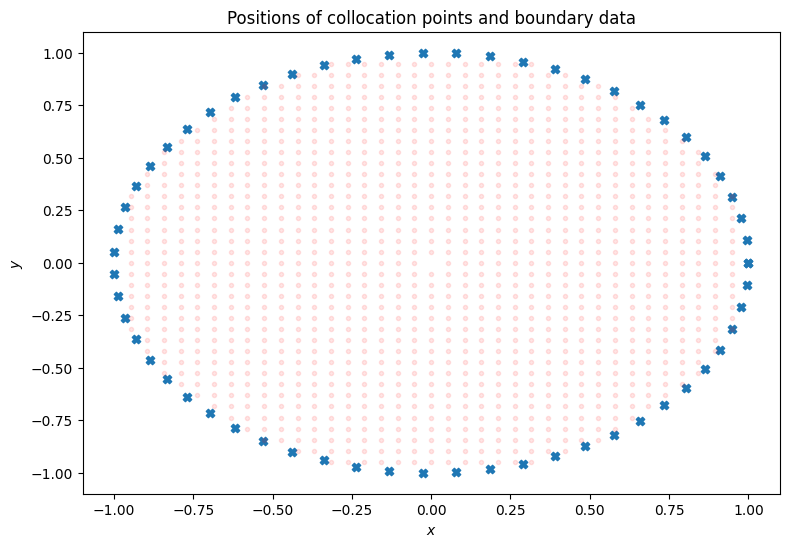

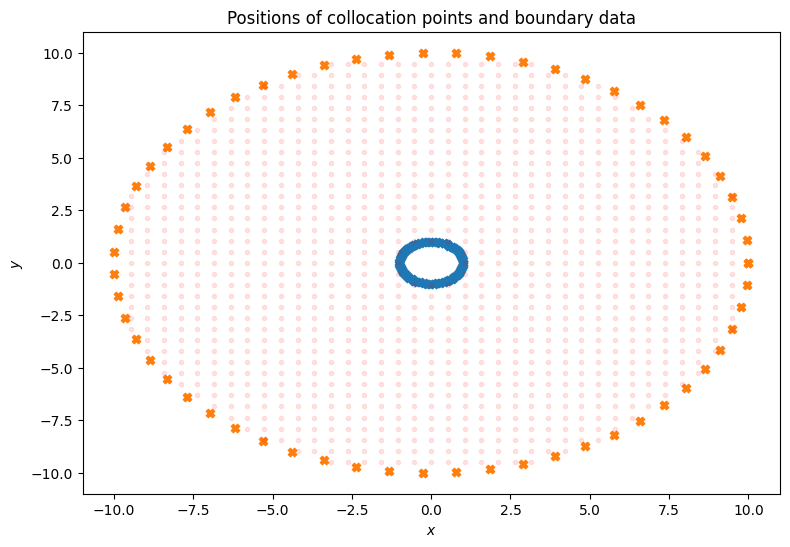

In [2]:
XPINN_solver = XPINN(PINN)

domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04

vf = (1/(2*np.pi*10))*np.log(10)
lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':vf, 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([500],[5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.load_NeuralNets('.saved_models',['Test_precond_in','Test_precond_ext'],[lr,lr])

In [3]:
Post = View_results_X(XPINN_solver,View_results)

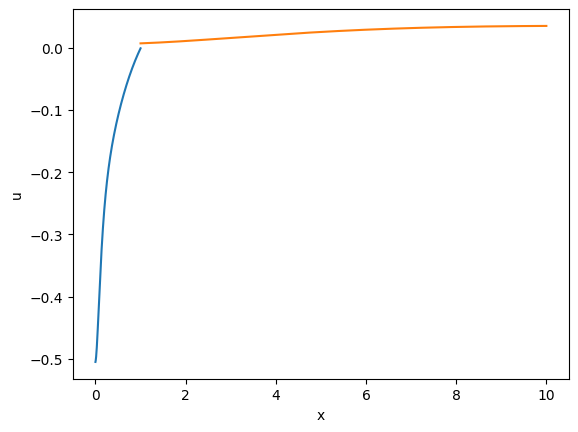

In [4]:
Post.plot_u_plane()

In [5]:
XPINN_solver.solve(N=1000, flag_time=True)

It 00000: loss = 5.97124398e-01
It 00050: loss = 1.09807462e-01
It 00100: loss = 1.01492673e-01
It 00150: loss = 9.36642513e-02
It 00200: loss = 1.98056921e-02
It 00250: loss = 2.05471702e-02
It 00300: loss = 1.88366994e-02
It 00350: loss = 2.09446959e-02
It 00400: loss = 2.16649156e-02
It 00450: loss = 4.63468246e-02
It 00500: loss = 5.81460446e-03
It 00550: loss = 4.62088548e-03
It 00600: loss = 4.51934291e-03
It 00650: loss = 4.42351867e-03
It 00700: loss = 4.32774238e-03
It 00750: loss = 4.23220778e-03
It 00800: loss = 4.13704058e-03
It 00850: loss = 4.04250342e-03
It 00900: loss = 3.94876627e-03
It 00950: loss = 3.85601376e-03

Computation time: 124.60502910614014 seconds


In [6]:
Post = View_results_X(XPINN_solver,View_results)

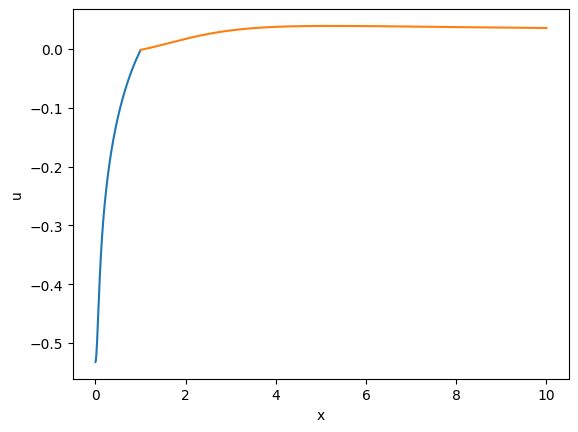

In [7]:
Post.plot_u_plane()

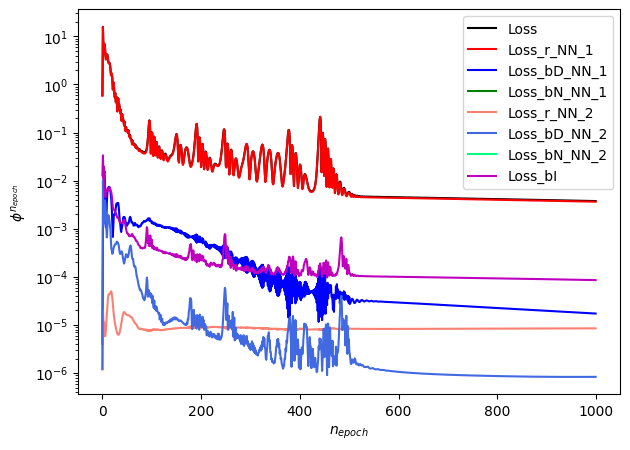

In [8]:
Post.plot_loss_history();